WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Original class distribution:
Admission
0    273
1    127
Name: count, dtype: int64

Balanced class distribution:
Admission
0    127
1    127
Name: count, dtype: int64


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 39 seconds.


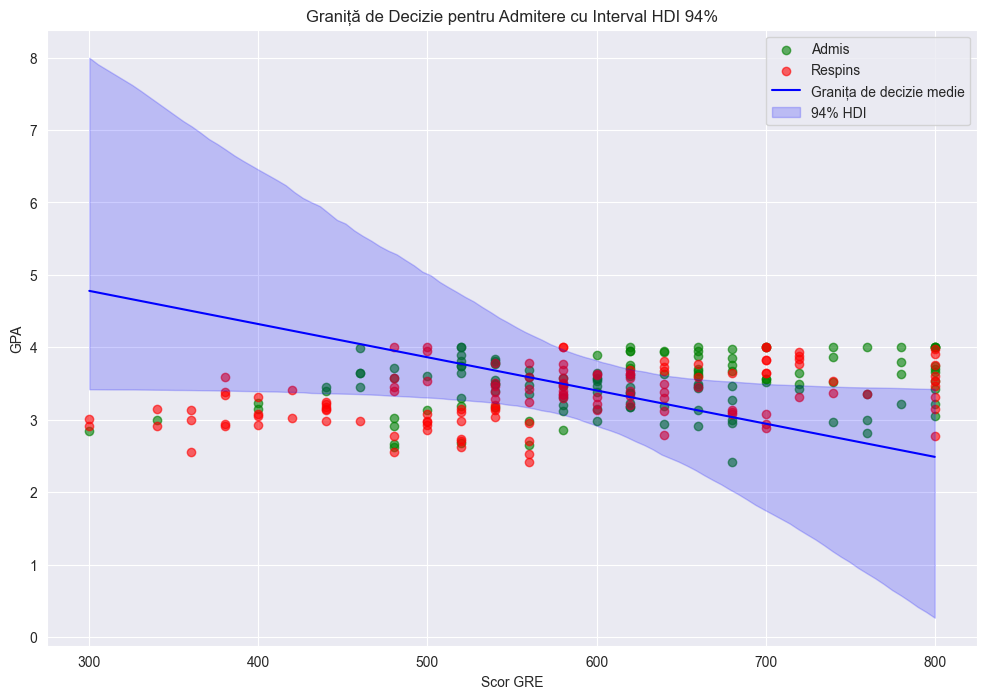


Rezultate pentru studentul 1 (GRE=550, GPA=3.5):
Probabilitate medie de admitere: 0.489
Interval HDI 90%: [0.428, 0.551]

Rezultate pentru studentul 2 (GRE=500, GPA=3.2):
Probabilitate medie de admitere: 0.392
Interval HDI 90%: [0.324, 0.464]


In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

# Read the data
data = pd.read_csv('Admission.csv')
X_gre = data['GRE'].values
X_gpa = data['GPA'].values
y = data['Admission'].values

# Create a DataFrame with all features
df = pd.DataFrame({
    'GRE': X_gre,
    'GPA': X_gpa,
    'Admission': y
})

# Separate majority and minority classes
df_majority = df[df['Admission'] == 0]
df_minority = df[df['Admission'] == 1]

# Print the original class distribution
print("Original class distribution:")
print(df['Admission'].value_counts())

# Undersample majority class
df_majority_undersampled = resample(df_majority, 
                                  replace=False,
                                  n_samples=len(df_minority),
                                  random_state=42)

# Combine minority class with undersampled majority class
df_balanced = pd.concat([df_majority_undersampled, df_minority])

# Get the balanced features and target
X_gre = df_balanced['GRE'].values
X_gpa = df_balanced['GPA'].values
y = df_balanced['Admission'].values

# Print the new class distribution
print("\nBalanced class distribution:")
print(df_balanced['Admission'].value_counts())

# Standardize predictors
X_gre_std = (X_gre - X_gre.mean()) / X_gre.std()
X_gpa_std = (X_gpa - X_gpa.mean()) / X_gpa.std()

# The rest of your original code remains the same
with pm.Model() as model:
    # Prior distributions
    beta0 = pm.Normal('beta0', mu=0, sigma=10)
    beta1 = pm.Normal('beta1', mu=0, sigma=10)
    beta2 = pm.Normal('beta2', mu=0, sigma=10)
    
    # Calculate admission probability
    logit_p = beta0 + beta1 * X_gre_std + beta2 * X_gpa_std
    p = pm.Deterministic('p', pm.math.sigmoid(logit_p))
    
    # Likelihood
    y_obs = pm.Bernoulli('y_obs', p=p, observed=y)
    
    # Sampling
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

# The rest of your functions and visualization code remains the same...

# Funcție pentru calculul graniței de decizie
def calculate_decision_boundary(trace, X_gre_mean, X_gre_std, X_gpa_mean, X_gpa_std):
    beta0_samples = trace.posterior['beta0'].values.flatten()
    beta1_samples = trace.posterior['beta1'].values.flatten()
    beta2_samples = trace.posterior['beta2'].values.flatten()
    
    gre_range = np.linspace(X_gre.min(), X_gre.max(), 100)
    decision_boundaries = []
    
    for b0, b1, b2 in zip(beta0_samples, beta1_samples, beta2_samples):
        gpa_boundary = -(b0 + b1 * ((gre_range - X_gre_mean) / X_gre_std)) / b2
        gpa_boundary = gpa_boundary * X_gpa_std + X_gpa_mean
        decision_boundaries.append(gpa_boundary)
    
    mean_boundary = np.mean(decision_boundaries, axis=0)
    hdi_lower = np.percentile(decision_boundaries, 3, axis=0)
    hdi_upper = np.percentile(decision_boundaries, 97, axis=0)
    
    return gre_range, mean_boundary, hdi_lower, hdi_upper

# Calculul graniței de decizie și intervalului HDI
gre_range, mean_boundary, hdi_lower, hdi_upper = calculate_decision_boundary(
    trace, X_gre.mean(), X_gre.std(), X_gpa.mean(), X_gpa.std()
)

# Vizualizare
plt.figure(figsize=(12, 8))
plt.scatter(X_gre[y==1], X_gpa[y==1], c='green', label='Admis', alpha=0.6)
plt.scatter(X_gre[y==0], X_gpa[y==0], c='red', label='Respins', alpha=0.6)
plt.plot(gre_range, mean_boundary, 'b-', label='Granița de decizie medie')
plt.fill_between(gre_range, hdi_lower, hdi_upper, color='blue', alpha=0.2, label='94% HDI')
plt.xlabel('Scor GRE')
plt.ylabel('GPA')
plt.title('Graniță de Decizie pentru Admitere cu Interval HDI 94%')
plt.legend()
plt.grid(True)
plt.show()

# Funcție pentru calculul probabilității de admitere pentru un nou student
def calculate_admission_probability(trace, gre, gpa, X_gre_mean, X_gre_std, X_gpa_mean, X_gpa_std):
    gre_std = (gre - X_gre_mean) / X_gre_std
    gpa_std = (gpa - X_gpa_mean) / X_gpa_std
    
    beta0_samples = trace.posterior['beta0'].values.flatten()
    beta1_samples = trace.posterior['beta1'].values.flatten()
    beta2_samples = trace.posterior['beta2'].values.flatten()
    
    logit_p = beta0_samples + beta1_samples * gre_std + beta2_samples * gpa_std
    p_samples = 1 / (1 + np.exp(-logit_p))
    
    mean_prob = np.mean(p_samples)
    hdi_lower = np.percentile(p_samples, 5)
    hdi_upper = np.percentile(p_samples, 95)
    
    return mean_prob, hdi_lower, hdi_upper

# Calculul probabilității pentru primul student (GRE=550, GPA=3.5)
prob1, hdi_lower1, hdi_upper1 = calculate_admission_probability(
    trace, 550, 3.5, X_gre.mean(), X_gre.std(), X_gpa.mean(), X_gpa.std()
)

# Calculul probabilității pentru al doilea student (GRE=500, GPA=3.2)
prob2, hdi_lower2, hdi_upper2 = calculate_admission_probability(
    trace, 500, 3.2, X_gre.mean(), X_gre.std(), X_gpa.mean(), X_gpa.std()
)

print(f"\nRezultate pentru studentul 1 (GRE=550, GPA=3.5):")
print(f"Probabilitate medie de admitere: {prob1:.3f}")
print(f"Interval HDI 90%: [{hdi_lower1:.3f}, {hdi_upper1:.3f}]")

print(f"\nRezultate pentru studentul 2 (GRE=500, GPA=3.2):")
print(f"Probabilitate medie de admitere: {prob2:.3f}")
print(f"Interval HDI 90%: [{hdi_lower2:.3f}, {hdi_upper2:.3f}]")